# Numerical analysis of the Steinberg signature on more complex linear framework graphs. 

# Haque, Çetiner, Gunawardea 2024. _Anomalous behavior of the Steinberg signature for detecting departure from thermodynamic equilibrium._

To interrogate the behavior of the Steinberg signature on more complicated linear framework graphs, we make use of the `general_graphs` library. Here we provide a work-flow for creating random graphs, setting them at equilibrium, and assessing the Steinberg signature's behavior in response to increasing entropy production.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from general_graph_utils import *

# Plot features

In [2]:
# plot formatting
plt.rc("text", usetex=False) # renders LaTeX more quickly
plt.rc("font", family = "serif",size=14) # font specifications
plt.rc("figure",figsize=(14,12)) # figure size
%config InlineBackend.figure_format = 'retina' # retina-display quality

In [3]:
# hex codes

# black
black = '#000000'

# strawberry pink (A^{13})
strawberrypink = '#FF3D6E'

# sky blue (A^{31})
skyblue = '#4599DF'

## 1. Create a general graph with a random number of nodes and randomly assigned edges.

First, decide the maximum number of nodes you want in your graph. Set that number as `n`. Then, define a directed graph `G` and an undirected graph `G_ud` as the outputs of the function `random_graph(n)`. `random_graph(n)` picks a random number between 2 and `n` to be the size of the graph, adds that many nodes to the graph, and then randomly assigns edges between the nodes such that the resulting graph is strongly connected and fully reversible. It is necessary to have a directed and undirected version of the graph for the various functions that we will use going forward.

In [90]:
n=10
G,G_ud = random_graph(n)

In [91]:
print(G)
print(G_ud)

DiGraph with 4 nodes and 10 edges
Graph with 4 nodes and 5 edges


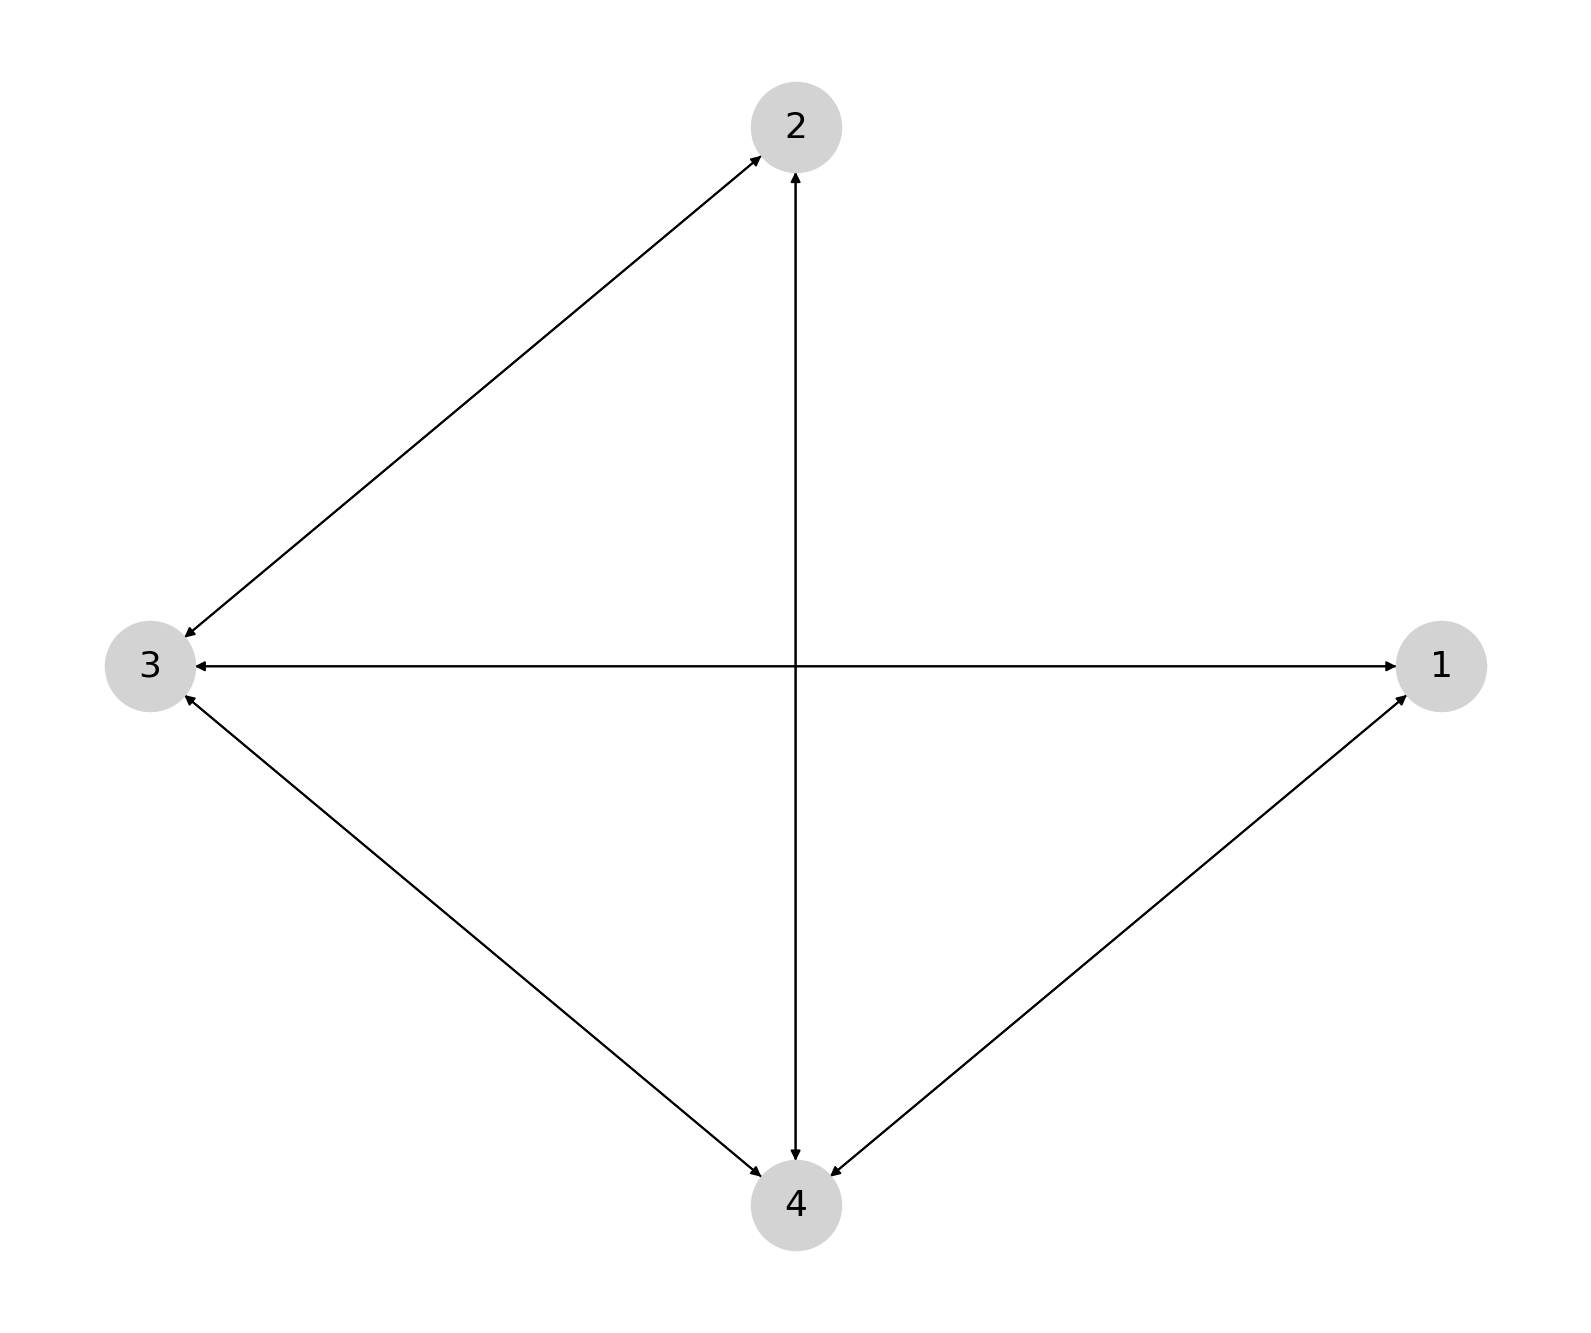

In [132]:
fig, ax = plt.subplots(figsize = (14, 12))
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, node_size=2000, node_color = 'lightgray', font_size=18, font_color='black', font_family='sans-serif')
fig.savefig('figure_4A.pdf', dpi = 900, bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')

## 2. Create data structures containing the graph's structural information.

Next, we will obtain structural information from the graph $G$ and assign this information to certain data structures. These data structures are important as they will be used to compute the cycle affinity for each cycle in the graph.

`node_list`: a NumPy array of the nodes in $G$.

In [93]:
node_list = get_nodes(G)
print(node_list)

[1 2 3 4]


`edge_list`: a NumPy array of the edges in $G$. Each directed edge $i \to j$ between vertices $i$ and $j$ is represented as a list `[i j]`

In [94]:
edge_list = get_edges(G)
print(edge_list)

[[1 3]
 [1 4]
 [2 3]
 [2 4]
 [3 1]
 [3 2]
 [3 4]
 [4 1]
 [4 3]
 [4 2]]


To define edge labels for $G$, we use the following algorithm. If G is not labeled, the labels are logarithmically sampled from the range $(10^{-3},10^3)$. Replace `np.around(10**(np.random.uniform(-3,3, size = 1)[0])` with `1.0` in the `elif` condition for troubleshooting purposes.

The function returns the following data structures.

`label_dict`: a dictionary matching each edge to its corresponding label. The keys are the edges (listed as a tuple $(i,j)$ for each directed edge $i\to j$ and the values are the associated labels.

`label_list`: a NumPy array containing a list of the labels in $G$. The order is the same as in `edge_list`, which can be confirmed from `label_dict`

In [95]:
def get_labels(G):
    """
    Extracts the label information for each edge in a NetworkX graph object. If G not labeled, labels are logarithmically sampled.
    
    Note: works for undirected graph, but if given a choice, better to use a directed graph
    
    Parameters
    ----------
    G : NetworkX graph object (directed)
            
    Returns
    -------
    label_dict : dictionary
        keys: edges in G represented as tuple (source,sink), values: edge labels
        
    label_list : 1D numpy array
        list of edge labels in G
        
    """
    
    label_dict = {}
    
    if nx.is_weighted(G)==True:
        for i in range(len(G.edges())):
            label_dict[list(G.edges())[i]] = G.get_edge_data(list(G.edges)[i][0],list(G.edges)[i][1])['weight']
        
    elif nx.is_weighted(G)==False:
        label_dict = {e: 1.0 for e in G.edges}
        # np.around(10**(np.random.uniform(-3,3, size = 1)[0]),decimals=5)
        
    label_list = np.fromiter(label_dict.values(), dtype=float)
    
    return label_dict, label_list

In [96]:
label_dict, label_list = get_labels(G)

In [97]:
print(label_dict)

{(1, 3): 1.0, (1, 4): 1.0, (2, 3): 1.0, (2, 4): 1.0, (3, 1): 1.0, (3, 2): 1.0, (3, 4): 1.0, (4, 1): 1.0, (4, 3): 1.0, (4, 2): 1.0}


In [98]:
print(label_list)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


To define a cycle basis, we take advantage of the NetworkX function `nx.cycle_basis`. More information can be found here: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.cycle_basis.html

`cycle_list`: a list of lists of the nodes involved in each cycle in $G$. Note that the undirected version of $G$ is needed as a parameter for this function.

In [99]:
def get_cycle_nodes(G_ud):
    """
    Returns a list of the cycles which form a basis G (must be undirected). Each element is a list of the nodes connected in a given cycle.
    
    Parameters
    ----------
    G_ud : NetworkX graph object (undirected)
            
    Returns
    -------
    cycle_list : list of lists
        each element is a list of the nodes connected in a given cycle.
    """
    
    cycle_list = [c for c in nx.cycle_basis(G_ud)]
    
    return cycle_list

In [100]:
cycle_list = get_cycle_nodes(G_ud)
num_cycles = len(cycle_list)
print(cycle_list)

[[4, 3, 1], [4, 2, 3]]


Going forward, it will be useful to know which edges (and their corresponding labels) are associated with specific cycles. The following algorithm creates data structures that hold this information.

`cycle_edges_forward`: a list of lists where each element is a list of the edges going around one direction ("forward") of a given cycle

`cycle_edges_backward`: a list of lists where each element is a list of the edges going around the opposite direction ("backward") of a given cycle

`cycle_labels_forward`: a list of lists where each element is a list of the labels associated with the forward edges

`cycle_labels_backward`: a list of lists where each element is a list of the labels associated with the backward edges

In [101]:
def get_cycle_labels_edges(cycle_list,label_dict):
    """
    Extracts, for each cycle, the edges involved and their respective edge labels.
    
    Parameters
    ----------    
    cycle_list : list of lists
        each element is a list of the nodes connected in a given cycle.
        
    label_dict : dictionary
        keys: edges in G represented as tuple (source,sink), values: edge labels
        
    Returns
    -------
    cycle_edges_forward : list of lists
        each element is a list of the edges going around one direction of a given cycle
    
    cycle_edges_backward : list of lists
        each element is a list of the edges going around the opposite direction of a given cycle
    
    cycle_labels_forward : list of lists
        each element is a list of the labels going around one direction of a given cycle
    
    cycle_labels_backward : list of lists
        each element is a list of the labels going around the opposite direction of a given cycle
        
    """
    
    # define number of cycles
    num_cycles = len(cycle_list)
    
    # define arrays for edges in each direction
    cycle_edges_forward = [[] for i in range(num_cycles)]
    cycle_edges_backward = [[] for i in range(num_cycles)]
    
    # define arrays for labels in each direction
    cycle_labels_forward = [[] for i in range(num_cycles)]
    cycle_labels_backward = [[] for i in range(num_cycles)]

    # iterate over each cycle
    for j in range(num_cycles):
        
        for i in range(1,len(cycle_list[j])):
            
            source = cycle_list[j][i-1]
            sink = cycle_list[j][i]
            
            # edge (source,sink) and accompanying labels
            cycle_labels_forward[j].append(label_dict.get((source,sink)))
            cycle_edges_forward[j].append((source,sink))
            
            #edge (sink, source) and accompanying labels
            cycle_labels_backward[j].append(label_dict.get((sink,source)))
            cycle_edges_backward[j].append((sink,source))
        
        # account for the connection between the last and first elements of each cycle list
        final_source = cycle_list[j][-1]
        final_sink = cycle_list[j][0]

        # edge (final_source, final_sink) and accompanying labels
        cycle_labels_forward[j].append(label_dict.get((final_source,final_sink)))
        cycle_edges_forward[j].append((final_source,final_sink))
        
        # edge (final_sink, final source) and accompanying labels
        cycle_labels_backward[j].append(label_dict.get((final_sink,final_source)))
        cycle_edges_backward[j].append((final_sink,final_source))
        
    return cycle_edges_forward, cycle_edges_backward, cycle_labels_forward, cycle_labels_backward

In [102]:
cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)

In [103]:
print(cycle_edges_forward)
print(cycle_edges_backward)

[[(4, 3), (3, 1), (1, 4)], [(4, 2), (2, 3), (3, 4)]]
[[(3, 4), (1, 3), (4, 1)], [(2, 4), (3, 2), (4, 3)]]


In [104]:
print(cycle_labels_forward)
print(cycle_labels_backward)

[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]


## 3. Calculate the cycle affinity for each cycle in the graph

The cycle affinity is a dimensionless quantity that serves as a measure of thermodynamic force. Mathematically, we define the cycle affinity in the following way. Let $C = i \leftrightharpoons 1 \leftrightharpoons 2 \leftrightharpoons \cdots \leftrightharpoons j \leftrightharpoons i$ represent a cycle of reversible edges in a graph. For any cycle $C$, the cycle affinity $\tilde{A}(C)$ is given by

$$ \tilde{A}(C) = ln \left ( \dfrac{\ell(i\to 1)\ell(1\to 2)\cdots \ell(j \to i)}{\ell(1\to i)\ell(2\to 1)\cdots \ell(i \to j)} \right ) $$

where $\ell(a \to b)$ is the label on the directed edge $a \to b$. To compute this quantity for each cycle in the graph, we must complete the following steps.

1. Calculate the products of edge labels in each direction around each cycle.
2. Take the log of the ratio of the forward and backwards products for each cycle

`products_f`: 1D NumPy array where each element is the product of labels corresponding to the forward traversal of each cycle

`products_b`: 1D NumPy array where each element is the product of labels corresponding to the backward traversal of each cycle

In [105]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)

In [106]:
print(products_f)
print(products_b)

[1. 1.]
[1. 1.]


`total_affinities`: 1D NumPy array where each element is the thermodynamic force for each cycle in the graph, corresponding to their order in cycle_list

In [107]:
total_affinities = calculate_affinities(products_b, products_f, cycle_list)

In [108]:
print(total_affinities)

[0. 0.]


## 3. Calculate the Steinberg signature

The Steinberg signature is a signature of non-equilibrium conditions in Markovian systems. Using higher-order autocorrelation functions of the form $G^{\alpha,\beta}(\tau)$ and $G^{\beta,\alpha}(\tau)$, this method allows one to detect whether or not a given system obeys detailed balance. 

We can use the Steinberg signature to detect if the parameterization of a particular linear framework graph obeys detailed balance or not. The Steinberg signature takes multiple forms, including the following formula.

$$G^{\alpha,\beta}(\tau) = f^\alpha e^{L \tau} f^{* \beta} \pi$$

We will first define some quantities that will pass as variables in the Steinberg function. We will then compute the Laplacian matrix of the graph. Finally, when we have all the requisite components, we can compute the Steinberg signature.

In [109]:
def make_observable(node_list):
    """
    Create the observable vector f for a graph with size num_nodes = len(node_list). The observable vector is a function on the states of the Markov process defined for the linear framework graph: when the system exists in state k, f takes vaue f_k.
    
    Parameters
    ----------
    node_list : 1D array
        list of nodes in the graph
    
    Returns
    -------
    f : 1D array
        list of values that the observable f assumes based on the state the Markov process exists in at a given time t 
    
    """
    
    num_nodes = len(node_list)
    
    f = []
    
    for i in range(0,num_nodes):
        f.append(3+(2*i))
    
    return f

In [110]:
signal = make_observable(node_list)
print(signal)

[3, 5, 7, 9]


`tau`: a vector of possible values of $\tau$. $\tau$ represents the interval.

In [111]:
tau = np.arange(start=0.01,stop=2.0,step=0.01)

`L`: the Laplacian matrix of the graph

In [112]:
L = Laplacian_all(edge_list, label_list, node_list)
print(L)

[[-2.  0.  1.  1.]
 [ 0. -2.  1.  1.]
 [ 1.  1. -3.  1.]
 [ 1.  1.  1. -3.]]


In [113]:
pi = steady_state_spectrum(L)

`t`: forward higher-order autocorrelation function $G^{\alpha,\beta}(\tau)$

`t_rev`: reverse higher-order autocorrelation function $G^{\beta, \alpha}(\tau)$

In [114]:
%%time
a_13, a_31 = asymmetric_autocorrelation(signal,L,tau,pi,alpha=1,beta=3)

CPU times: user 130 ms, sys: 7.02 ms, total: 137 ms
Wall time: 146 ms


In [115]:
area = np.abs(np.trapz(a_13)-np.trapz(a_31))
print(area)

3.6607161746360361576e-11


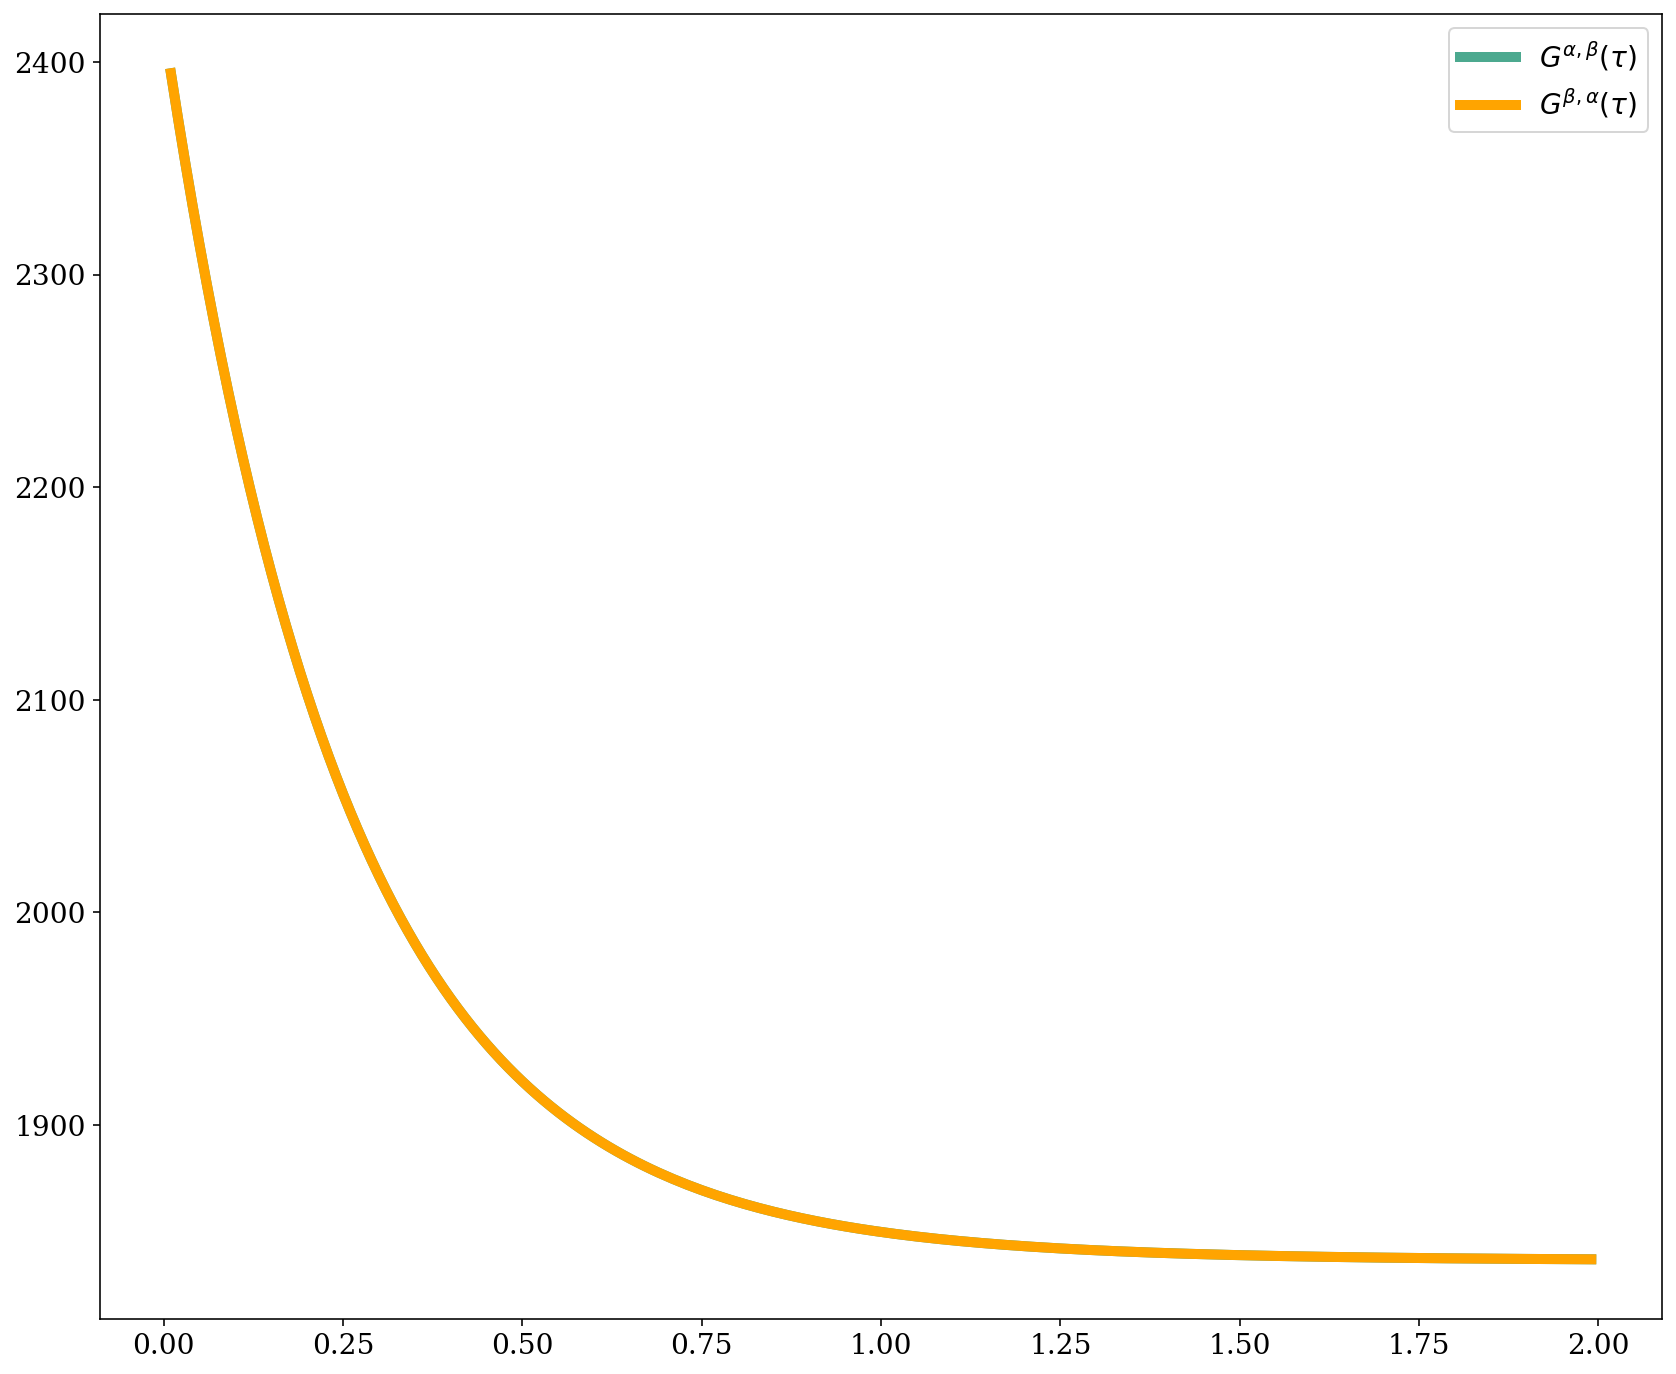

In [116]:
fig = plt.figure()
plt.plot(tau,a_31,color='#4CA98F',linewidth=5,label=r'$G^{\alpha,\beta}(\tau)$')
plt.plot(tau,a_13,c= '#FFA400',linewidth=5,label=r'$G^{\beta,\alpha}(\tau)$')
plt.legend()

## 4. Set the graph in an equilibrium steady state

Linear framework graphs represent biochemical systems. The vertices represent components of a system, and edges are treated as chemical reactions under mass-action kinetics with the labels as rate constants (Gunawardena 2012). The dynamics on this system relaxes to a **steady-state** when $dx/dt = 0$, where $x$ is a column vector of component amounts.

Furthermore, we can define two types of steady-states: equilibrium and non-equilibrium. An equilibrium steady-state is characterized by the lack of net fluxes of matter and energy. Detailed balance holds for each pair of reversible edges, and the cycle affinity for each cycle is equal to 0. 

In [117]:
def initial_equilibrium_parameters(cycle_list,cycle_edges_forward,cycle_labels_forward,cycle_labels_backward):
    """
    Initializes a graph with a particular parameterization in an equilibrium steady state
    
    Parameters
    ----------
    cycle_list : list of lists
        each element is a list of the nodes connected in a given cycle.

    cycle_edges_forward : list of lists
        each element is a list of the edges going around one direction of a given cycle

    cycle_labels_forward : list of lists
        each element is a list of the labels going around one direction of a given cycle
    
    cycle_labels_backward : list of lists
        each element is a list of the labels going around the opposite direction of a given cycle

    Returns
    -------
    
    cycle_labels_forward : list of lists
        updated with new values for certain edges
        
    edge_tracker : list of lists
        list of edges with labels that were changed to initialize the system in an equilibrium steady state
    
    """
    
    num_cycles = len(cycle_list)
    edge_tracker = []
    
    # for each cycle in cycle_list
    for i in range(num_cycles):
        for j in range(len(cycle_list[i])):
            
            # if the edge is already in edge_tracker, move on
            if cycle_edges_forward[i][j] in edge_tracker:
                pass
            
            # otherwise, change the value of one edge in the cycle such that the cycle affinity is 0
            else:
                cycle_labels_forward[i][j] = 1/(np.prod(cycle_labels_forward[i])/(cycle_labels_forward[i][j]*np.prod(cycle_labels_backward[i])))
                
                # add that edge to edge_tracker
                edge_tracker.append(cycle_edges_forward[i][j])
    
    return cycle_labels_forward, edge_tracker

In [118]:
cycle_labels_forward, edge_tracker = initial_equilibrium_parameters(cycle_list,cycle_edges_forward,cycle_labels_forward,cycle_labels_backward)

In [119]:
cycle_labels_forward

[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]

In [120]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
total_affinities = calculate_affinities(products_f, products_b, cycle_list)
print(total_affinities)

[0. 0.]


In [121]:
def reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list):
    """
    Initializes a graph with a particular parameterization in an equilibrium steady state
    
    Parameters
    ----------
    
    cycle_list : list of lists
        each element is a list of the nodes connected in a given cycle.
    
    cycle_labels_forward : list of lists
        updated with new values for certain edges
        
    edge_tracker : list of lists
        list of edges with labels that were changed to initialize the system in an equilibrium steady state
        
    label_dict : dictionary
        keys: edges in G represented as tuple (source,sink), values: edge labels
        
    label_list : 1D numpy array
        list of edge labels in G
    
    Returns
    -------
    
    label_dict : dictionary
        keys: edges in G represented as tuple (source,sink), values: edge labels (updated with equilibrium changes)
        
    label_list : 1D numpy array
        list of edge labels in G (updated with equilibrium changes
    """
    
    num_cycles = len(cycle_list)
    
    for i in range(num_cycles):
        label_dict[edge_tracker[i]] = cycle_labels_forward[i][0]
        
    label_list = np.fromiter(label_dict.values(), dtype=float)
    
    return label_dict, label_list

In [122]:
label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)

In [123]:
L = np.around(Laplacian_all(edge_list, label_list, node_list),decimals=4)
print(L)

[[-2.  0.  1.  1.]
 [ 0. -2.  1.  1.]
 [ 1.  1. -3.  1.]
 [ 1.  1.  1. -3.]]


In [124]:
pi = steady_state_spectrum(L)

In [125]:
a_13, a_31 = asymmetric_autocorrelation(signal,L,tau,pi,alpha=1,beta=3)

In [126]:
area = np.abs(np.trapz(a_13)-np.trapz(a_31))
print(area)

3.6607161746360361576e-11


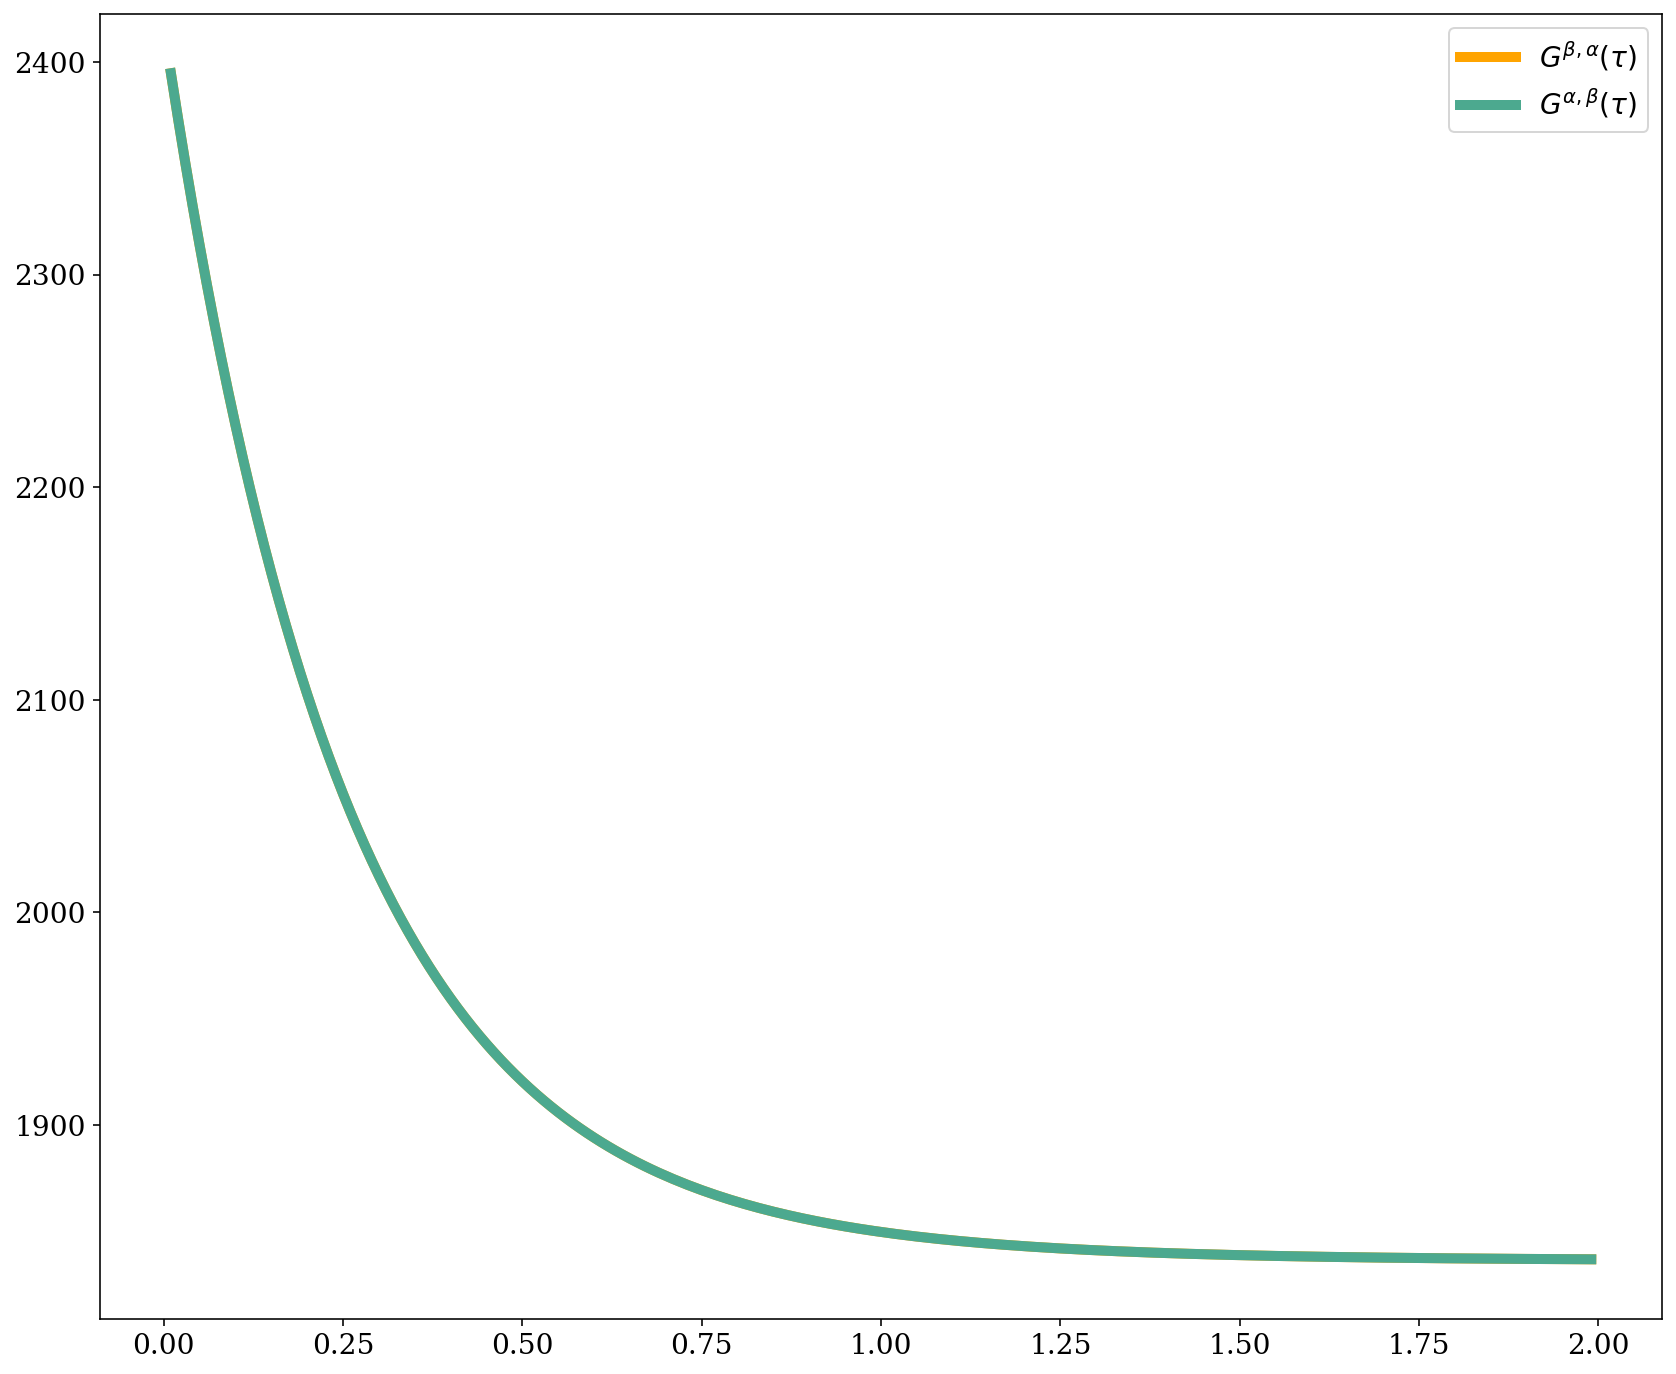

In [127]:
fig = plt.figure()
plt.plot(tau,a_13,c= '#FFA400',linewidth=5,label=r'$G^{\beta,\alpha}(\tau)$')
plt.plot(tau,a_31,color='#4CA98F',linewidth=5,label=r'$G^{\alpha,\beta}(\tau)$')
plt.legend()

# 5. Calculate a force-area curve

The goal of developing this software was to determine the sensitivity of the Steinberg signature to the thermodynamic force of the underlying system.

In [128]:
N = 2000
all_affinities = np.zeros((N,num_cycles))
all_areas = np.zeros((N,1))
param_changes = np.zeros((N,1))

In [129]:
for i in tqdm(range(0,N)):
    
    # calculate affinity + record
    products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
    total_affinities = calculate_affinities(products_f,products_b,cycle_list)
    all_affinities[i] = total_affinities
    
    # calculate area + record
    label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)
    L = Laplacian_all(edge_list,label_list,node_list)
    pi = steady_state_spectrum(L)
    a_13, a_31 = asymmetric_autocorrelation(signal,L,tau,pi,alpha=1,beta=3)
    all_areas[i] = np.abs(np.trapz(a_13)-np.trapz(a_31))
    
    # perturb parameter + record
    param_changes[i] = cycle_labels_forward[0][0]
    cycle_labels_forward[0][0] = cycle_labels_forward[0][0]*1.01

100%|█████████████████████████████████████████| 2000/2000 [04:32<00:00,  7.33it/s]


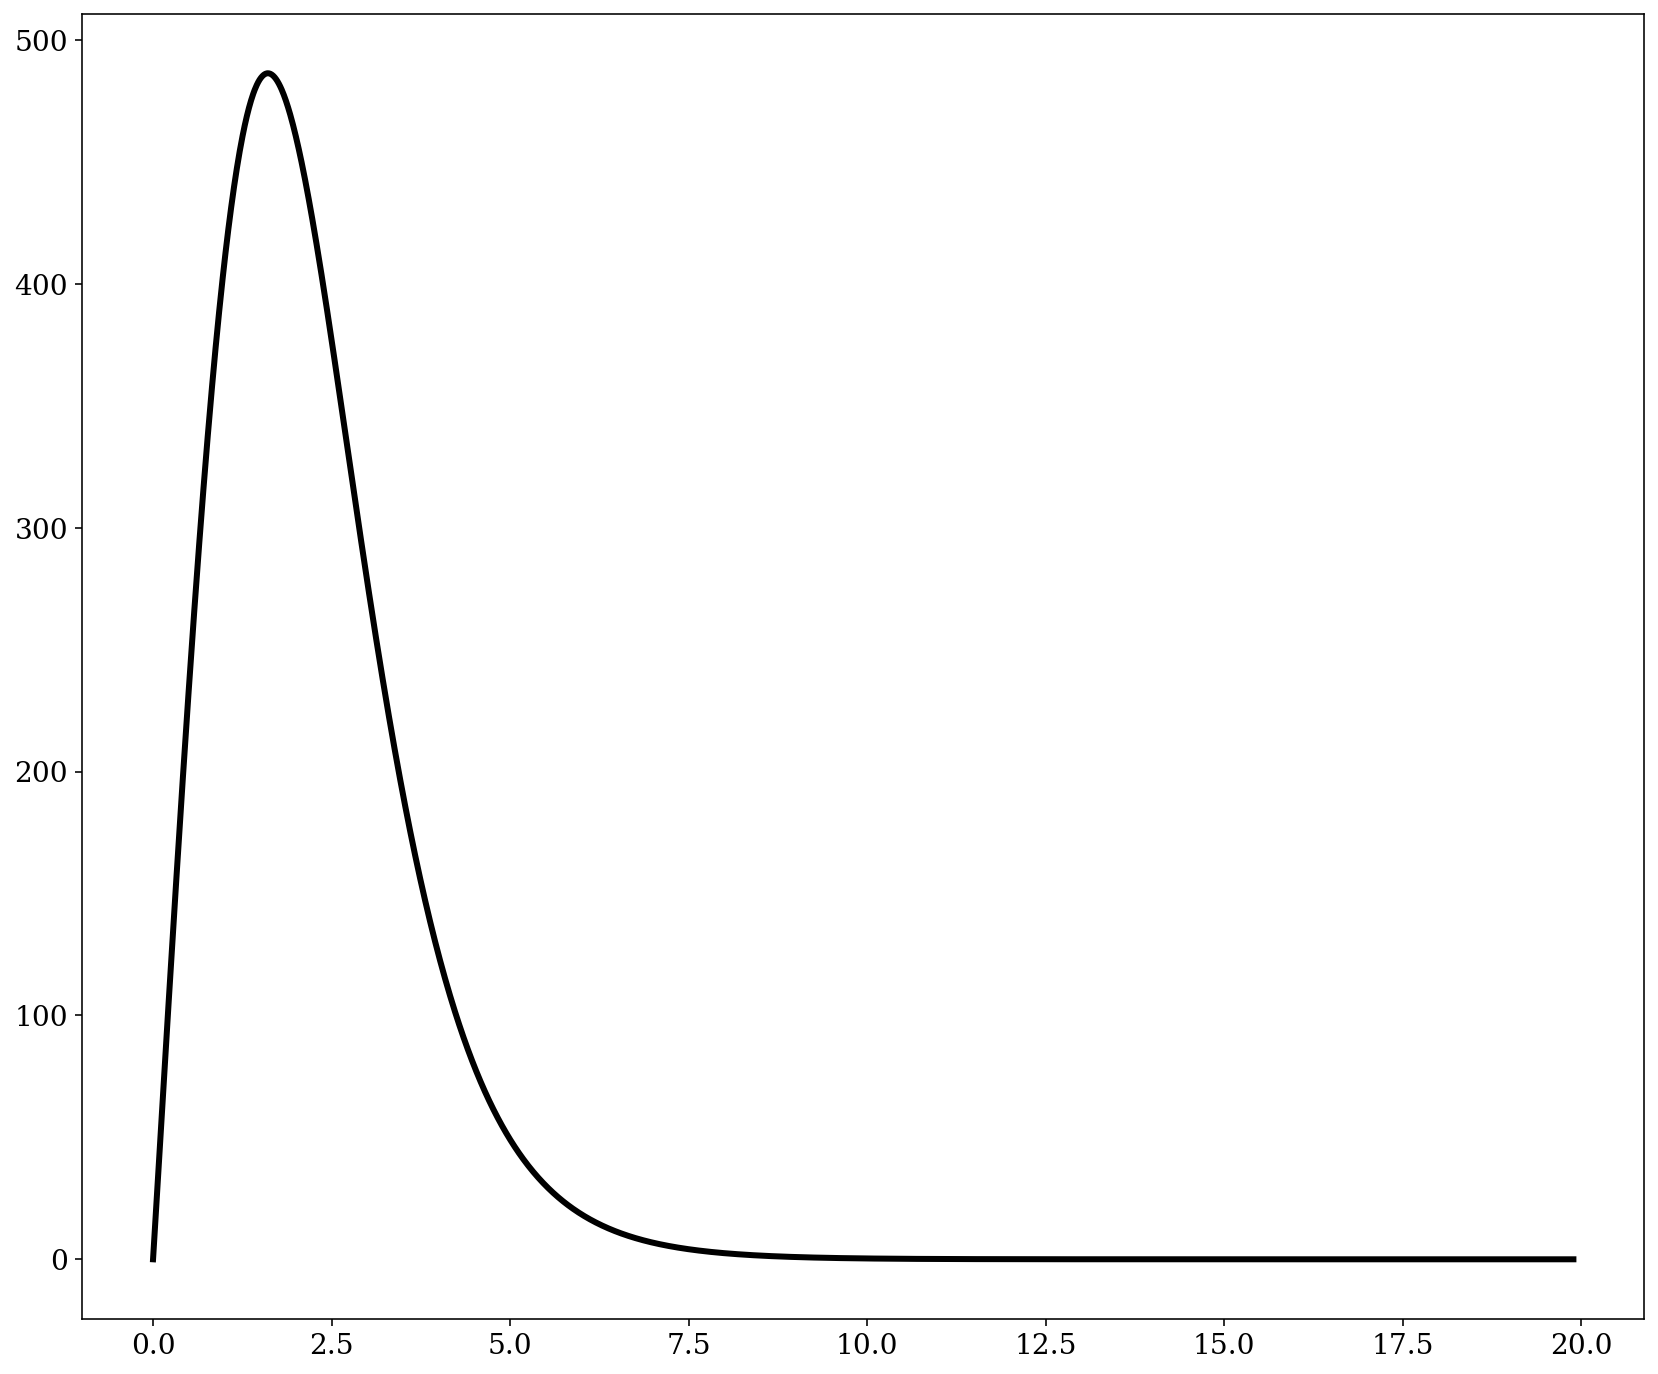

In [131]:
fig, ax = plt.subplots(figsize = (14, 12))
plt.plot(all_affinities[:,0],all_areas, linewidth=3, color = '#000000',label='cycle'+str(i))
plt.show()
fig.savefig('figure_4B.pdf', dpi = 900, bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')

In [310]:
n=6
G,G_ud = random_graph(n)

In [338]:
print(G)
print(G_ud)

DiGraph with 5 nodes and 16 edges
Graph with 5 nodes and 8 edges


In [340]:
G.add_edges_from([(3,4),(4,3)])
G_ud.add_edges_from([(3,4),(4,3)])

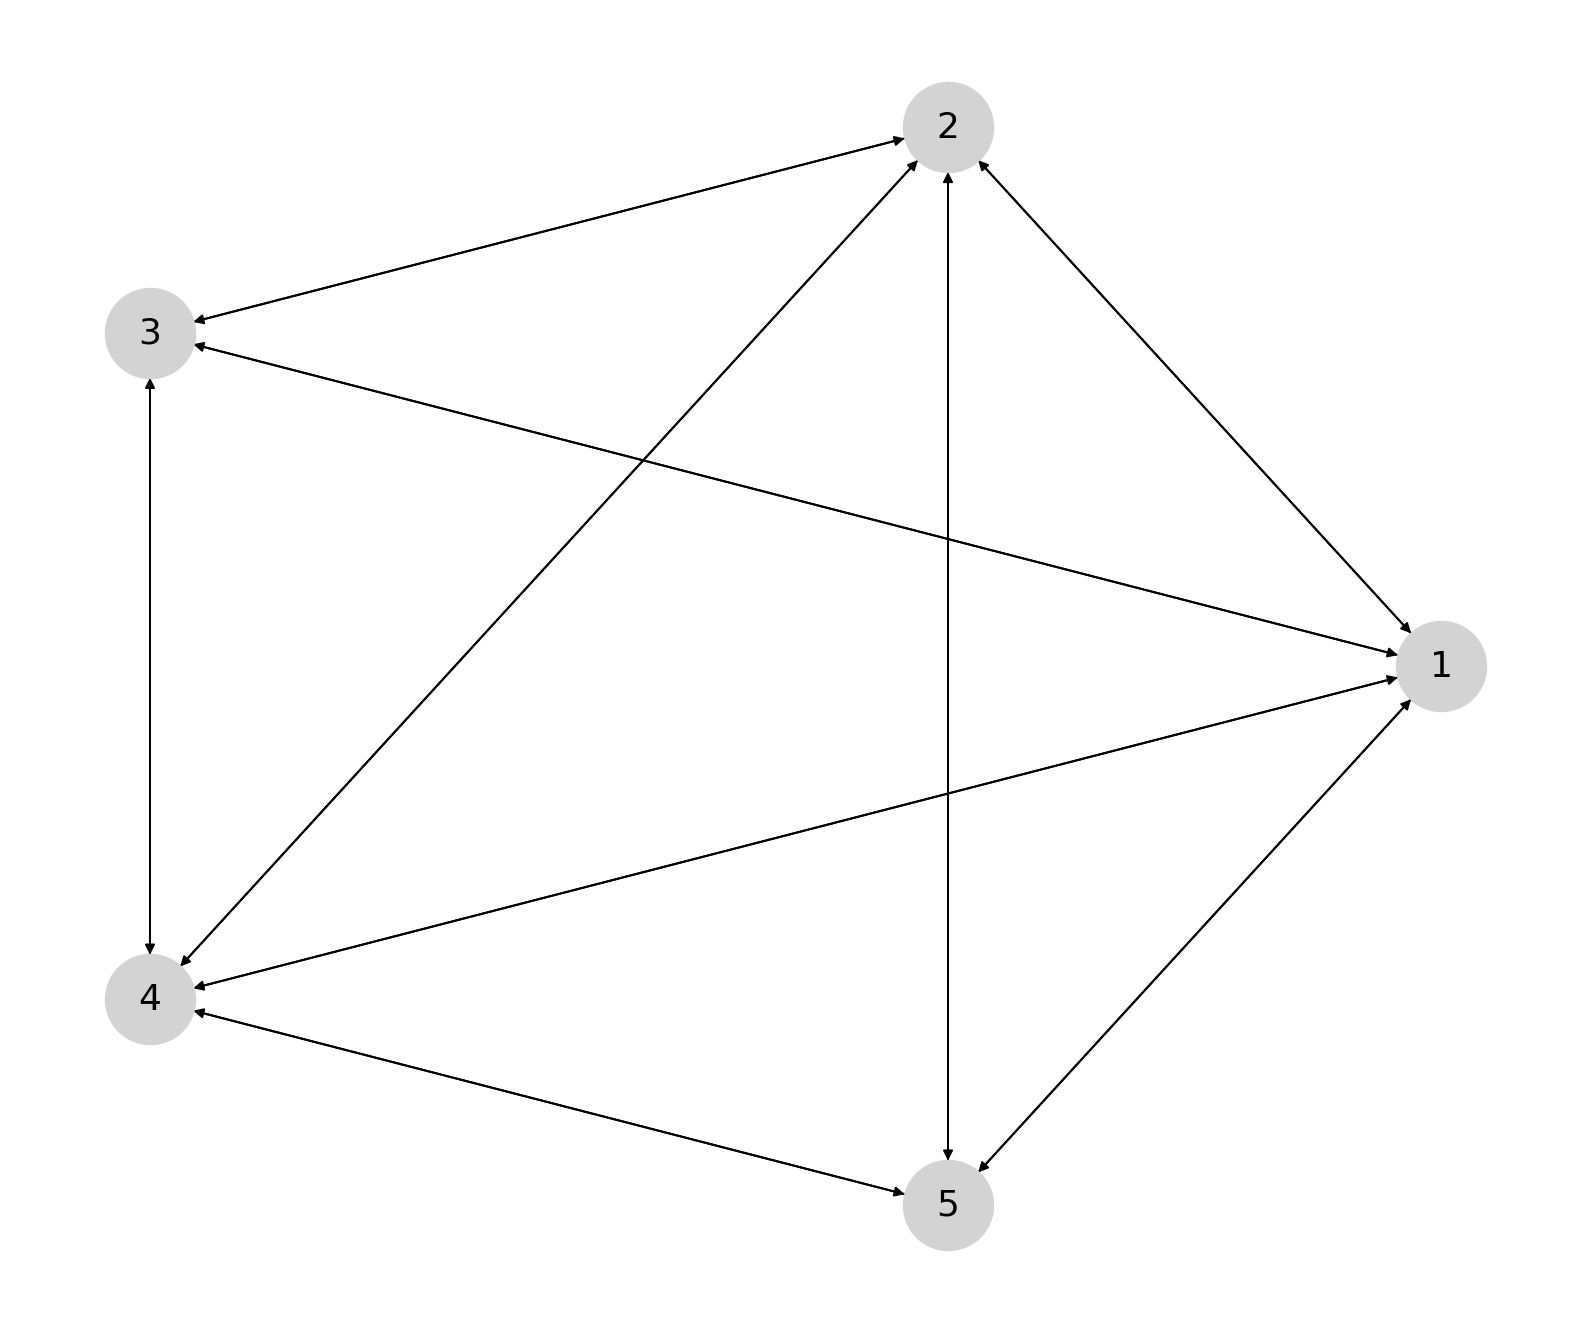

In [341]:
fig, ax = plt.subplots(figsize = (14, 12))
nx.draw(G, pos=nx.circular_layout(G), with_labels=True, node_size=2000, node_color = 'lightgray', font_size=18, font_color='black', font_family='sans-serif')
fig.savefig('figure_4C.pdf', dpi = 900, bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')

In [342]:
node_list = get_nodes(G)
print(node_list)

[1 2 3 4 5]


In [343]:
edge_list = get_edges(G)
print(edge_list)

[[1 2]
 [1 3]
 [1 4]
 [1 5]
 [2 5]
 [2 4]
 [2 3]
 [2 1]
 [3 1]
 [3 2]
 [3 4]
 [4 5]
 [4 2]
 [4 1]
 [4 3]
 [5 1]
 [5 2]
 [5 4]]


In [344]:
label_dict, label_list = get_labels(G)

In [345]:
print(label_dict)

{(1, 2): 1.0, (1, 3): 1.0, (1, 4): 1.0, (1, 5): 1.0, (2, 5): 1.0, (2, 4): 1.0, (2, 3): 1.0, (2, 1): 1.0, (3, 1): 1.0, (3, 2): 1.0, (3, 4): 1.0, (4, 5): 1.0, (4, 2): 1.0, (4, 1): 1.0, (4, 3): 1.0, (5, 1): 1.0, (5, 2): 1.0, (5, 4): 1.0}


In [346]:
print(label_list)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [347]:
cycle_list = get_cycle_nodes(G_ud)
num_cycles = len(cycle_list)
print(cycle_list)

[[5, 4, 1], [2, 4, 1], [3, 4, 1], [2, 3, 1], [5, 2, 1]]


In [348]:
cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)

In [349]:
print(cycle_edges_forward)
print(cycle_edges_backward)

[[(5, 4), (4, 1), (1, 5)], [(2, 4), (4, 1), (1, 2)], [(3, 4), (4, 1), (1, 3)], [(2, 3), (3, 1), (1, 2)], [(5, 2), (2, 1), (1, 5)]]
[[(4, 5), (1, 4), (5, 1)], [(4, 2), (1, 4), (2, 1)], [(4, 3), (1, 4), (3, 1)], [(3, 2), (1, 3), (2, 1)], [(2, 5), (1, 2), (5, 1)]]


In [350]:
print(cycle_labels_forward)
print(cycle_labels_backward)

[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]


In [351]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)

In [352]:
print(products_f)
print(products_b)

[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]


In [353]:
total_affinities = calculate_affinities(products_b, products_f, cycle_list)

In [354]:
print(total_affinities)

[0. 0. 0. 0. 0.]


In [355]:
signal = make_observable(node_list)
print(signal)

[3, 5, 7, 9, 11]


In [356]:
tau_n = np.arange(start=0.01,stop=2.0,step=0.01)

In [357]:
L = Laplacian_all(edge_list, label_list, node_list)
print(L)

[[-4.  1.  1.  1.  1.]
 [ 1. -4.  1.  1.  1.]
 [ 1.  1. -3.  1.  0.]
 [ 1.  1.  1. -4.  1.]
 [ 1.  1.  0.  1. -3.]]


In [358]:
cycle_labels_forward, edge_tracker = initial_equilibrium_parameters(cycle_list,cycle_edges_forward,cycle_labels_forward,cycle_labels_backward)

In [359]:
cycle_labels_forward

[[1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0]]

In [360]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
total_affinities = calculate_affinities(products_f, products_b, cycle_list)
print(total_affinities)

[0. 0. 0. 0. 0.]


In [361]:
label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)

In [362]:
L = np.around(Laplacian_all(edge_list, label_list, node_list),decimals=4)
print(L)

[[-4.  1.  1.  1.  1.]
 [ 1. -4.  1.  1.  1.]
 [ 1.  1. -3.  1.  0.]
 [ 1.  1.  1. -4.  1.]
 [ 1.  1.  0.  1. -3.]]


In [363]:
area = np.abs(np.trapz(t)-np.trapz(t_rev))
print(area)

2.7239366318099200726e-10


In [364]:
N = 2000
all_affinities = np.zeros((N,num_cycles))
all_areas = np.zeros((N,1))
param_changes = np.zeros((N,1))

In [365]:
for i in tqdm(range(0,N)):
    
    # calculate affinity + record
    products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
    total_affinities = calculate_affinities(products_f,products_b,cycle_list)
    all_affinities[i] = total_affinities
    
    # calculate area + record
    label_dict, label_list = reformat_labels(cycle_list, cycle_labels_forward, edge_tracker, label_dict, label_list)
    L = Laplacian_all(edge_list,label_list,node_list)
    pi = steady_state_spectrum(L)
    a_13, a_31 = asymmetric_autocorrelation(signal,L,tau,pi,alpha=1,beta=3)
    all_areas[i] = np.abs(np.trapz(a_13)-np.trapz(a_31))
    
    # perturb parameter + record
    param_changes[i] = cycle_labels_forward[0][0]
    cycle_labels_forward[0][0] = cycle_labels_forward[0][0]*1.01

100%|█████████████████████████████████████████| 2000/2000 [06:03<00:00,  5.50it/s]


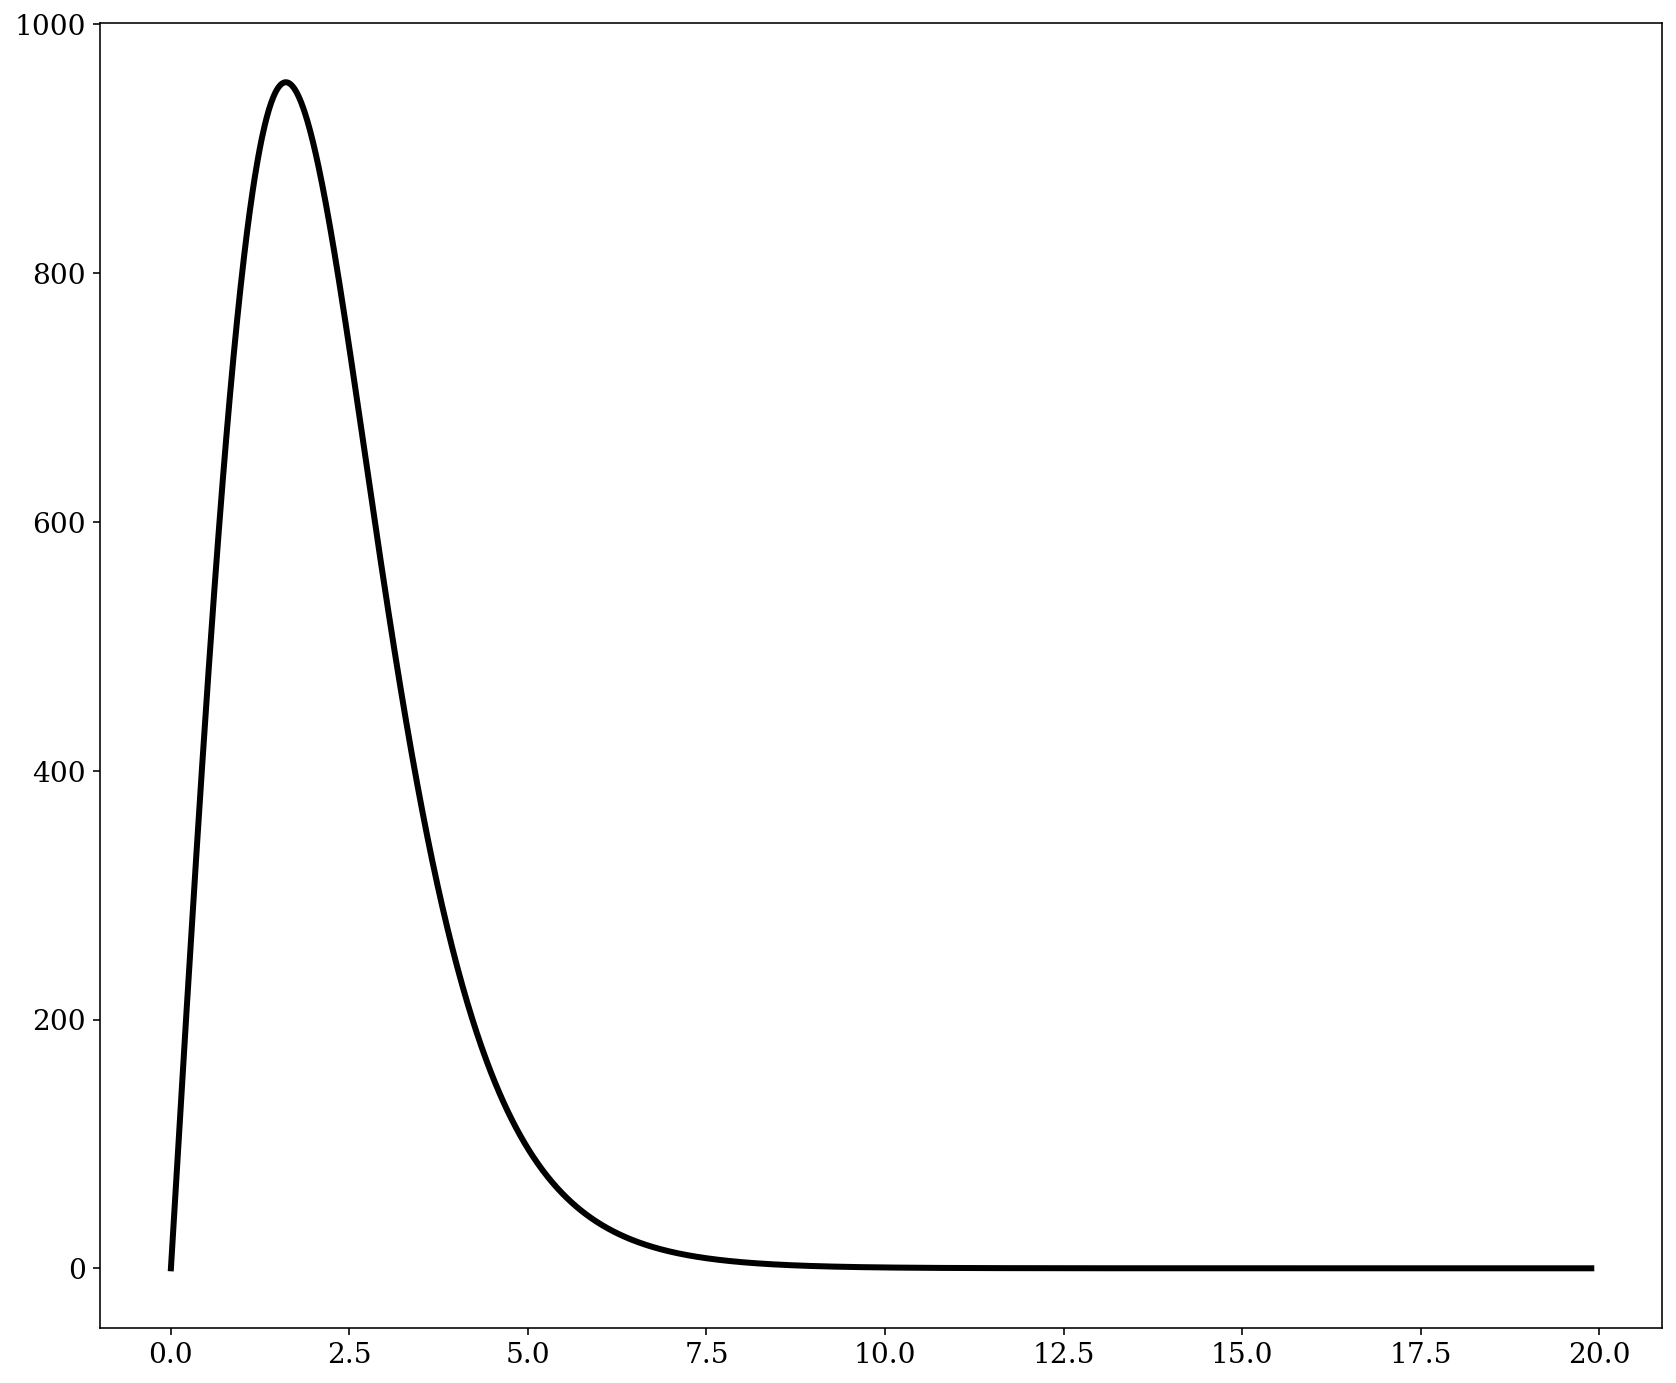

In [337]:
fig, ax = plt.subplots(figsize = (14, 12))
plt.plot(all_affinities[:,0],all_areas, linewidth=3, color = '#000000',label='cycle'+str(i))
plt.show()
fig.savefig('figure_4D.pdf', dpi = 900, bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')